In this assignment, you are going to implement Algorithm 8.1 (Factorization algorithm for multiple-view reconstruction) from textbook.

In [235]:
import json
import math
import os
import os.path as osp
import random
import sys
from glob import glob

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA

First, we load the SceneCity Urban 3D (SU3) dataset from the disk.  This synthetic dataset contains the ground truth junctions and lines for each image and their correspondance among images.  The following code loads the dataset and display the lines and junctions.  The same junction and line instances in difference images have the same value in `lineidx` and `juncidx`, and therefore they will have the same color in the following demo images.

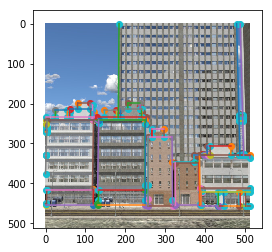

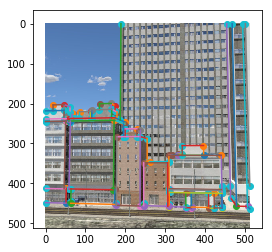

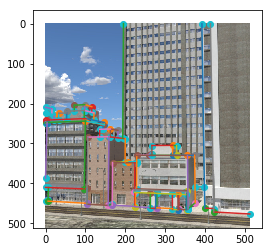

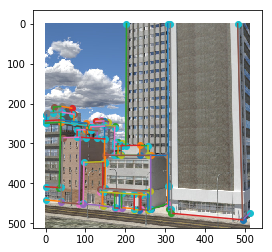

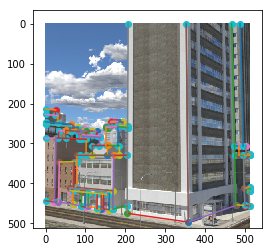

In [236]:
N_IMAGE = 5

color = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fs = glob("data/00/*_0.jpg")
fs.sort()
lines = []
juncs = []
lineids = []
juncids = []
images = []
Rt = [] # world to camera matrix (for verification purpose only. DO NOT USE THIS MATRIX IN YOUR IMPLEMENTATION)
K = None # camera to pixel matrix

for fjpg in fs[:N_IMAGE]:
    fjs = fjpg.replace(".jpg", "_label.json")
    js = json.load(open(fjs))

    line = js["line"]
    lineidx = js["lineidx"]
    junc = np.array(js["junction"])
    juncidx = js["junindex"]
    K = js["K"]
    Rt.append(np.array(js["RT"]))

    junc[:, 1] *= -1
    junc *= 256
    junc += 256

    lines.append(line)
    juncs.append(junc)
    lineids.append(lineidx)
    juncids.append(juncidx)
    
    I = cv2.imread(fjpg)[..., ::-1]
    plt.figure()
    plt.imshow(I)
    images.append(I)
    for ln, idx in zip(line, lineidx):
        idx += len(color)
        plt.plot(
            [junc[ln[0], 0], junc[ln[1], 0]],
            [junc[ln[0], 1], junc[ln[1], 1]],
            c=color[idx % len(color)],
        )
    for jun, idx in zip(junc, juncidx):
        idx += len(color)
        plt.scatter(jun[0], jun[1], c=color[idx % len(color)])

# convert projection matrix (OpenGL format) to OpenCV format to avoid confusion
# the unit of the projection matrix is pixel now (OpenCV format).
# If you are still confusing, you may want to read
#     http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/OWENS/LECT9/node2.html
#     https://github.com/vvvv/VL.OpenCV/wiki/Coordinate-system-conversions-between-OpenCV,-DirectX-and-vvvv
K = np.array([[K[0][0] * 256, 0            , 256], 
              [0            , K[1][1] * 256, 256], 
              [0            , 0            , 1]])

Next, we need to extract the common junctions from multiple images and put them in a numpy array.  **You need to implement this function.**  You can refer to the demo code that visualize the dataset. Notice that T-junctions are not real junctions in 3D (their `juncidx` is -1, i.e., cyan dots in the demo images) so they should not be included.

25 common junction extracted from 5 images


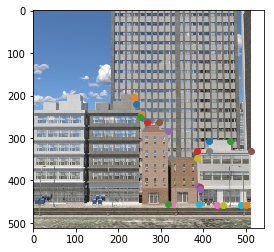

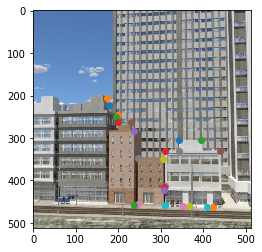

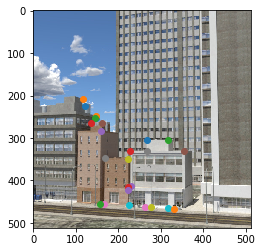

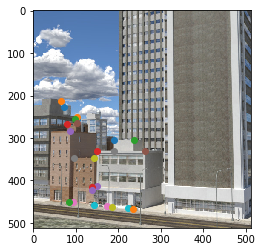

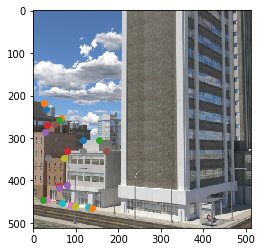

In [237]:
def extract_corresponding_junction(juncs, juncids):
    same = set(juncids[0])
    for i in range(4):
        same &= set(juncids[i+1])
    same = list(same)
    same = same[0:-1]
    xs = np.zeros([len(juncs), len(same) ,2])
    for i in range(5):
        for j in range(len(same)):
            number = juncids[i].index(same[j])
            xs[i][j] = juncs[i][number]
    return xs 
    
xs = extract_corresponding_junction(juncs, juncids)
print(xs.shape[1], "common junction extracted from", len(juncs), "images")
# visualize common junctions
color = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for im_i, I in enumerate(images):
    plt.imshow(I)
    for pt_i, (y, x) in enumerate(xs[im_i]): 
        plt.scatter(y, x, c=color[pt_i % len(color)])
    plt.show()

In [238]:
def hat(x):
    x.reshape(3,1)
    return np.array([[0,-x[2],x[1]],[x[2],0,-x[0]],[-x[1],x[0],0]])

def im2cam(pixels, K):
    x = pixels[:, 1]
    y = pixels[:, 0]
    z = np.ones_like(x)
    pixel_coor = np.stack([x, y, z]).T
    return pixel_coor @ np.linalg.inv(K).T

def cam2im(X, K):
    _X = np.divide(X, X[:, 2, np.newaxis])
    im = _X @ K.T
    return np.array([im[:, 1], im[:, 0]]).T

def eight_point_algorithm(corr):
    A=np.zeros((corr.shape[1],9))
    
    x1=corr[0]
    x2=corr[1]
    X1=x1[1]
    X2=x2[1]
    for i in range(corr.shape[1]):
        A[i]=[x1[i,0]*x2[i,0], x1[i,0]*x2[i,1], x1[i,0]*x2[i,2],
                x1[i,1]*x2[i,0], x1[i,1]*x2[i,1], x1[i,1]*x2[i,2],
                x1[i,2]*x2[i,0], x1[i,2]*x2[i,1], x1[i,2]*x2[i,2] ]

    U,S,Vh=np.linalg.svd(A)
    E0 = ((Vh)[-1].reshape(3,3)).T
    if np.linalg.det(E0) < 0:
        E0 = -E0
    U1,S1,V1=np.linalg.svd(E0)

    S1_n=np.diag([1,1,0])
    
    R_z1=np.array([[0,1,0],[-1,0,0],[0,0,1]])
    R_z2=np.array([[0,-1,0],[1,0,0],[0,0,1]])
    R_z=[R_z1,R_z2]
    
    for R_z_R in R_z:
        for R_z_T in R_z:
            T_hat=U1@R_z_R@S1_n@U1.T
            R_=U1@R_z_T.T@V1
            T_=np.array([[T_hat[2,1]],[-T_hat[2,0]],[T_hat[1,0]]])
            if hat(T_)@X2@hat(T_)@R_@(X1)>0 and hat(X2)@R_@X1@hat(X2)@T_<0 and hat(R_@X1)@X2@hat(R_@X1)@T_ > 0:
                print(LA.det(R_))
                T=T_
                R=R_
    
    return R, T



Here is the most intereseting part. **Implement Algorithm 8.1 (Factorization algorithm for multiple-view reconstruction) from the textbook.**

In [239]:
def factorization_algorithm(xs, K):
    N_IMAGE=len(xs);
    N_POINTS=len(xs[0])
    x = np.zeros([N_IMAGE, N_POINTS ,3])    
    for i in range(N_IMAGE):
        x[i]=np.hstack(( xs[i],np.ones([N_POINTS,1])))
        x[i] = x[i] @ (np.linalg.inv(K).T)

    Rs = np.zeros([N_IMAGE, 3 , 3])
    Ts = np.zeros([N_IMAGE, 3, 1])
    alpha_ = np.zeros([N_POINTS])
    alpha = np.zeros([N_POINTS])
    x_re=np.zeros([ N_POINTS ,3]) 

    for k in range(10):
        if(k==0):
            R2,T2 = eight_point_algorithm(x[[0,1]])
            for j in range(N_POINTS):
                alpha_[j] = -((hat(x[1][j]) @ T2).T @ hat(x[1][j]) @ R2 @ x[0][j])/ ((hat(x[1][j]) @ T2).T @(hat(x[1][j]) @ T2))
            alpha = alpha_/alpha_[0]
        for i in range(N_IMAGE):
            P = np.zeros([3*N_POINTS,12])
            for n in range(N_POINTS):    
                    P[3*n:3*n+3]= np.hstack( ( np.kron(x[0][n],hat(x[i][n])),alpha[n]*hat(x[i][n]) ) )
            U,S,Vh=np.linalg.svd(P)
            R_ = (Vh[-1][:9].reshape(3,3)).T
            T_ = (Vh[-1][9:12].reshape(3,1))
            U,S,Vh=np.linalg.svd(R_)
            
            Rs[i]=np.sign(np.linalg.det(U@Vh)) * U @ Vh
            Ts[i]=np.sign(np.linalg.det(U@Vh)) / np.power(np.linalg.det(np.diag(S)),1/3) * T_
        for j in range(N_POINTS):
            up=0
            down=0
            for i in range(N_IMAGE-1):
                up += ((hat(x[i+1][j]) @ Ts[i+1]).T @ hat(x[i+1][j]) @ Rs[i+1] @ x[0][j].T)
                down += ((hat(x[i+1][j]) @ Ts[i+1]).T @(hat(x[i+1][j]) @ Ts[i+1]))
            alpha_[j]= - up/down
            alpha = alpha_/alpha_[0]
        for i in range(N_IMAGE):
            Ts[i]=Ts[i]*alpha_[0]

    
    for j in range(N_POINTS):
        x_re[j] = (( (Rs[1]@ x[0][j].T / alpha[j])) + Ts[1].T )
        x_re[j]=x_re[j]/x_re[j][2]

    return alpha, Rs, Ts # YOUR CODE
    
alpha, Rs, Ts = factorization_algorithm(xs, K)

1.0000000000000004


We provide some sanity checks. Execute them to verify you result.

In [240]:
# Verification
for i in range(N_IMAGE):
    # R should be a rotation matrix
    assert np.allclose(Rs[i] @ Rs[i].T, np.eye(3), atol=1e-4), i
    # compare with ground truth
    Rt_gt =    Rt[i] @ np.linalg.inv(Rt[0])
    
    R_gt = Rt_gt[:3, :3]
    T_gt = Rt_gt[:3, 3]
    print("------------ image ",i," -----------")
    print("GT:")
    print(R_gt,T_gt)
    print("Compute")
    print(Rs[i],Ts[i])

------------ image  0  -----------
GT:
[[ 1.00000000e+00 -1.61473516e-25  2.06683233e-24]
 [ 1.93474164e-23  1.00000000e+00 -1.48315419e-17]
 [ 3.44135068e-24 -1.62624155e-17  1.00000000e+00]] [0. 0. 0.]
Compute
[[ 1.00000000e+00  5.52851772e-16  1.95751592e-15]
 [-5.52851772e-16  1.00000000e+00  6.13491475e-17]
 [-1.95751592e-15  8.38071980e-17  1.00000000e+00]] [[ 3.60555500e-16]
 [-1.93798581e-16]
 [-6.52004529e-16]]
------------ image  1  -----------
GT:
[[ 0.987481   -0.01374778 -0.15713779]
 [ 0.01374778  0.9999049  -0.00108693]
 [ 0.1571378  -0.00108698  0.98757609]] [-0.15773807 -0.00109109 -0.01247132]
Compute
[[ 0.98748099  0.01374778  0.1571378 ]
 [-0.01374778  0.9999049  -0.00108692]
 [-0.1571378  -0.00108698  0.98757609]] [[-0.22533596]
 [ 0.00155868]
 [ 0.01781585]]
------------ image  2  -----------
GT:
[[ 0.95023747 -0.02715133 -0.31034115]
 [ 0.02715135  0.999622   -0.00432054]
 [ 0.31034116 -0.00432064  0.95061542]] [-0.3115267  -0.00433705 -0.04957318]
Compute
[[ 0.9

Finally, verify the correctness of your algorithm by reprojection the junctions from other views to the reference view and **visualize them using matplotlib**.

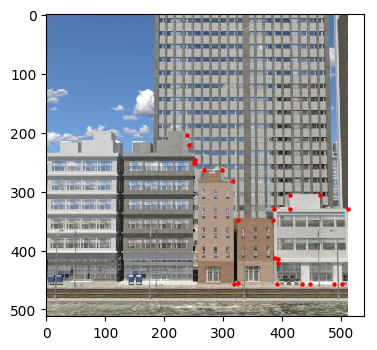

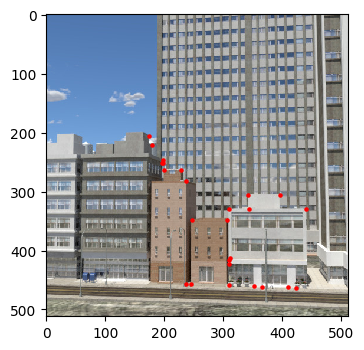

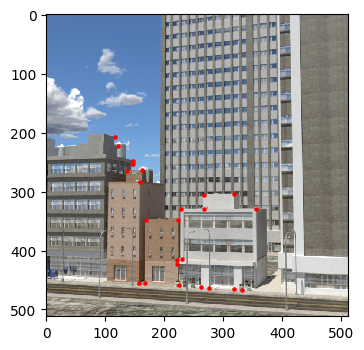

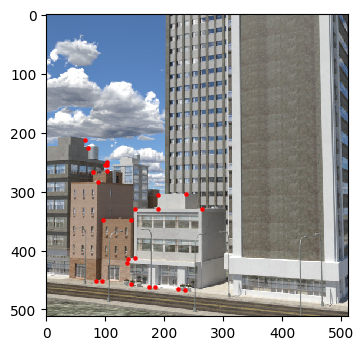

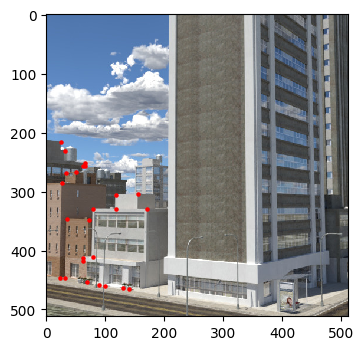

In [241]:
def visualize_reprojection(I, x, alpha, R, T, K):
    """Verify the algorithm by reproject x using R, T, and K to I. Visualization using matplotlib.
    Args:
      I: image (new view)
      x: coordinate of junctions in reference view
      alpha: inversion of depth of each junction in the first view with shape [N_POINTS]
      R: rotation with respect to the reference
      T: translation with respect to the reference
      K: camera projection matrix 
    """
    pviews = []
    N_IMAGE=len(xs);
    N_POINTS=len(xs[0])
    x_re=np.zeros([ N_POINTS ,3])   
    x=np.hstack(( x,np.ones([N_POINTS,1])))
    x = x @ (np.linalg.inv(K).T)
    for j in range(N_POINTS):
        x_re[j] =  (( (R @ x[j].T / alpha[j])) + T.T ) @ K.T
        x_re[j]=x_re[j]/x_re[j][2]
    plt.figure(dpi=100)
    plt.imshow(I)
    plt.scatter(x_re[:,0],x_re[:,1] , c='r', s=5)
    plt.show()

for i in range(N_IMAGE):
    visualize_reprojection(images[i], xs[0], alpha, Rs[i], Ts[i], K)

*Bonus Question (20%):* Modify the algorithm 8.1 so that it is able to handle the line in the SceneCity dataset. **Write down the pseudo-code.**

*Bonus Question (100%):* Implement your algorithm and verify its correctness.

# Line


1. Initialization at k = 0:

    (a)Transform the line section given by $(x_1,y_1)$into line's pre-image's normal vector $l_i$, (the coimage of the line)

    (b)Compute $[R_2,T_2]$ using eight-point algorithm with the coimages of the lines from the first and second scenes.

    (c)Compute $\alpha_k^j$ by $$\alpha_k^j = -\frac{(T_2^j)^{T}l_2^j ((l_2^j)^{T}R_2 l_1^j)}{||(l_2^j)^{T}R_2 l_1^j)||^2}$$
 
    (d) normalize $\alpha_j$:
$$\alpha_j = \alpha_j^i /\alpha_j^1$$

2. Compute $[\tilde{R_i},\tilde{T_i}]$ by doing SVD on $P_i$, where
$$P_j = \begin{bmatrix}\hat{l_1^1} \otimes  {l_i^1} ^T & \alpha_1 {l_i^1} ^T\\
\hat{l_1^2} \otimes  {l_i^2} ^T & \alpha_1 {l_i^2} ^T\\
... & ...\end{bmatrix}$$


 3. Compute $[{R_i},{T_i}]$ by $$\alpha_k^j = -\frac{\sum_{i=2}^{m}(T_i^j)^{T}l_i^j ((l_i^j)^{T}R_i l_1^j)}{\sum_{i=2}^{m}||(l_i^j)^{T}R_i l_i^j)||^2}$$
 
 4. Compute new $\alpha_j$ and k = k + 1. When reprojection error between lines and compute result are small enough, stop.

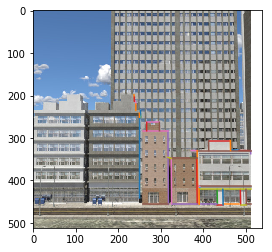

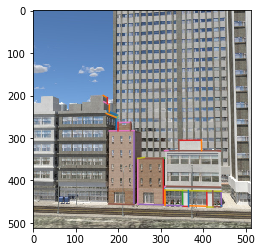

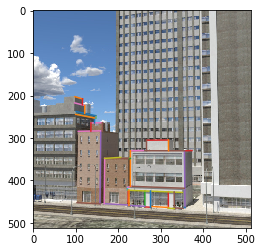

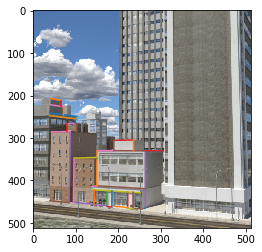

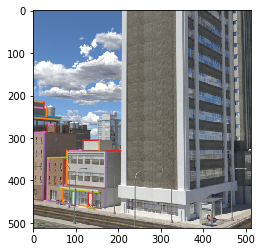

In [242]:
def extract_corresponding_line(lines, lineids):
    same = set(lineids[0])
    
    for i in range(4):
        same &= set(lineids[i+1])
    same = list(same)
    
    ls = np.zeros([len(lines), len(same) ,2])
    for i in range(5):
        for j in range(len(same)):
            number = lineids[i].index(same[j])
            ls[i][j] = lines[i][number]
    return ls,same


ls,same = extract_corresponding_line(lines, lineids)# visualize common lines
color = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for im_i, I in enumerate(images):
    plt.imshow(I)
    
    for ln, idx in zip(ls[im_i], same):
        idx += len(color)
        plt.plot(
            [juncs[im_i][int(ln[0]), 0], juncs[im_i][int(ln[1]), 0]],
            [juncs[im_i][int(ln[0]), 1], juncs[im_i][int(ln[1]), 1]],
            c=color[idx % len(color)],
        )
    
    plt.show()